# Testing for Out of distribution shift for word-based methods

## Imports

In [1]:
from transformers import BertTokenizer, BertModel
import torch
from datasets import load_dataset
from tqdm import tqdm

from nltk.tokenize import sent_tokenize, word_tokenize
import random

PyTorch version 1.6.0 available.


## Produce embeddings

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [3]:
def remove_sentence(t, k=1):
    sentences = random.sample(sent_tokenize(t), k)
    text = t
    for s in sentences:
        text = text.replace(s, '')
        assert len(t) != len(text)
    return text, len(word_tokenize(s))

def remove_word(t, k=1):
    text = t
    for _ in range(k):
        words = word_tokenize(text)
        if not len([i for i,w in enumerate(words) if w.isalnum()]):
            break
        word_idx = random.choice([i for i,w in enumerate(words) if w.isalnum()])
        del words[word_idx]
        text = ''.join([(' ' if w.isalnum() else '')+w for w in words]).strip(' ')
    return text
# def remove_word(t, k=1):
#     words = random.sample(word_tokenize(t), k)
#     text = t
#     for w in words:
#         text = text.replace(w, '')
#     return text

In [4]:
texts = []
dataset = load_dataset('squad', split='train')
for d in tqdm(dataset):
    if d['context'] not in texts:
        texts.append(d['context'])
        
n_samples = 10000
original = random.sample(texts, n_samples)#texts[:n_samples]
word_removed = []
sentence_removed = []
for t in tqdm(original):
    sr, nw = remove_sentence(t)
    wr = remove_word(t, k=nw)
    word_removed.append(wr)
    sentence_removed.append(sr)
# word_removed = [
#     remove_word(t, k=1) for t in texts
# ]
# sentence_removed = [
#     remove_sentence(t, k=1) for t in texts
# ]

Checking /Users/yvesrychener/.cache/huggingface/datasets/1825be4101447d340c1153faa326883028c67acd5c49bbf76ba67648fb87c216.85f43de978b9b25921cb78d7a2f2b350c04acdbaedb9ecb5f7101cd7c0950e68.py for additional imports.
Found main folder for dataset https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/squad/squad.py at /Users/yvesrychener/.cache/huggingface/modules/datasets_modules/datasets/squad
Found specific version folder for dataset https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/squad/squad.py at /Users/yvesrychener/.cache/huggingface/modules/datasets_modules/datasets/squad/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41
Found script file from https://raw.githubusercontent.com/huggingface/datasets/1.0.1/datasets/squad/squad.py to /Users/yvesrychener/.cache/huggingface/modules/datasets_modules/datasets/squad/1244d044b266a5e4dbd4174d23cb995eead372fbca31a03edc3f8a132787af41/squad.py
Found dataset infos file from https://raw.githubuse

In [5]:
texts = original+word_removed+sentence_removed
classes = [
    (n_samples, 'Original', 'tab:blue'),
    (n_samples, 'Word', 'tab:green'),
    (n_samples, 'Sentence', 'tab:red')
]

In [6]:
def process_texts(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    return model(**inputs)[0][:,0,:].detach()

In [7]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

In [8]:
results = []
for b in tqdm(batch(texts, 2), total=len(texts)/2):
    results.append(process_texts(b))

100%|██████████| 15000/15000.0 [1:44:39<00:00,  2.39it/s]  


In [9]:
embeddings = torch.cat(results, 0)

In [10]:
len(texts)

30000

In [11]:
embeddings.shape

torch.Size([30000, 768])

## TSNE, Visualisation & Wasserstein

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [13]:
def display(X, kind='kde'):
    if kind=='scatter':
        start = 0
        plt.figure(figsize=(16,8))
        for c in classes:
            end = start + c[0]
            plt.scatter(X[start:end,0], X[start:end,1], c=c[2], label=c[1], s=5, alpha=0.4)
            start = end
        plt.legend()
        plt.show()
    else:
        df = pd.DataFrame(X, columns=['x', 'y'])
        df['kind'] = [kind for c in classes for kind in [c[1]]*c[0]]
        plt.figure(figsize=(16,8))
        sns.kdeplot(data=df, x='x', y='y', hue='kind')
        plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
#X_hd = StandardScaler().fit_transform(embeddings)
X_hd = embeddings

In [15]:
TS = TSNE(n_jobs=-1, perplexity=100, init='pca', n_iter=5000)
X_tsne = TS.fit_transform(X_hd)

In [16]:
TS.n_iter

5000

In [17]:
TS.kl_divergence_

2.2636048793792725

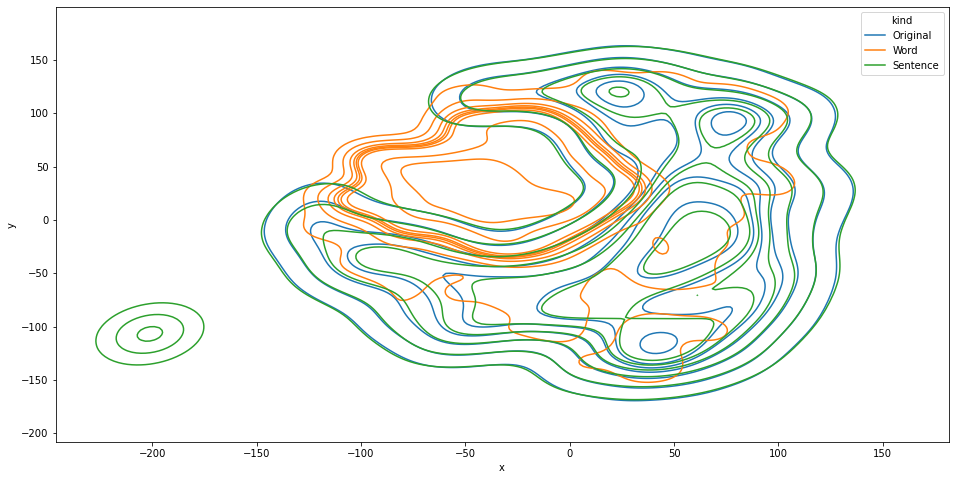

In [18]:
display(X_tsne)

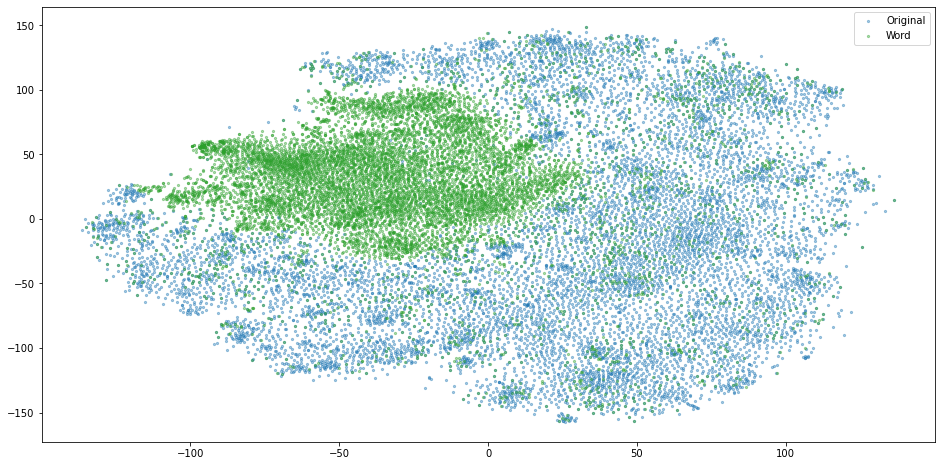

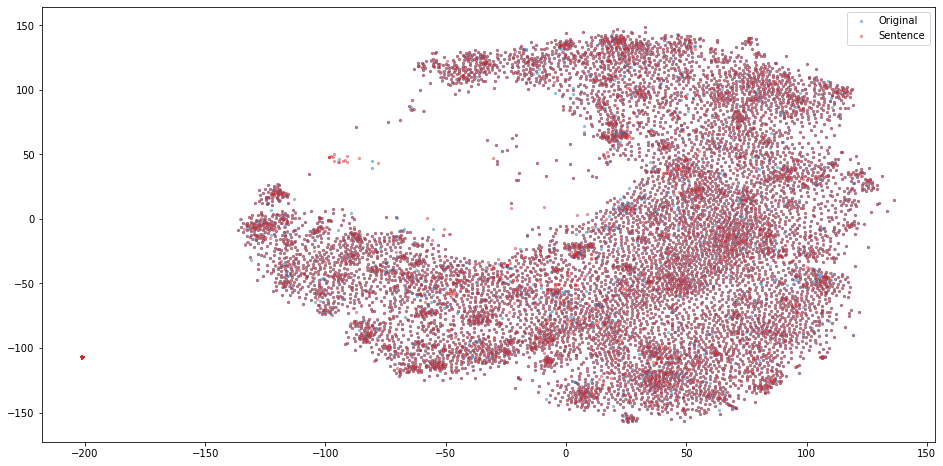

In [19]:
def scatter_filter(X, f=['Original', 'Word']):
    start = 0
    plt.figure(figsize=(16,8))
    for c in classes:
        end = start + c[0]
        if c[1] in f:
            plt.scatter(X[start:end,0], X[start:end,1], c=c[2], label=c[1], s=5, alpha=0.4)
        start = end
    plt.legend()
    plt.show()

scatter_filter(X_tsne)
scatter_filter(X_tsne, f=['Original', 'Sentence'])

In [20]:
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np

In [21]:
# extract samples matrices
X_original = X_hd[:classes[0][0], :]
X_word = X_hd[classes[0][0]:classes[0][0]+classes[1][0], :]
X_sentence = X_hd[classes[0][0]+classes[1][0]:, :]

In [22]:
def wasserstein_metric(X,Y,p=1):
    assert X.shape[0]==Y.shape[0]
    dist_m_p = cdist(X,Y)**p
    assignement = linear_sum_assignment(dist_m_p)
    return (dist_m_p[assignement].sum()/Y.shape[0])**(1/p)

In [23]:
print('Distribution shift by removing words: {}'.format(wasserstein_metric(X_original,X_word, p=2)))
print('Distribution shift by removing sentence: {}'.format(wasserstein_metric(X_original,X_sentence, p=2)))
print('(Calculated with 2-Wasserstein Distance)')

Distribution shift by removing words: 8.934183980988486
Distribution shift by removing sentence: 4.907113538264746
(Calculated with 2-Wasserstein Distance)


In [24]:
print('Distribution shift by removing words: {}'.format(wasserstein_metric(X_original,X_word, p=1)))
print('Distribution shift by removing sentence: {}'.format(wasserstein_metric(X_original,X_sentence, p=1)))
print('(Calculated with 1-Wasserstein Distance)')

Distribution shift by removing words: 8.608046598265714
Distribution shift by removing sentence: 4.094403440293689
(Calculated with 1-Wasserstein Distance)
